In [ ]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import time

# For showing images
from IPython.display import Image

import os
import sys

# Load mavenn
import mavenn


In [2]:
# Load and split data
#df = pd.read_csv('../result/NA_Epi_AA_Bei89.tsv',sep='\t')
from sklearn.utils import shuffle
df_all = pd.read_csv('../result/NA_compile_results.tsv',sep='\t') 
df_all = shuffle(df_all)
df_all = df_all[(df_all['strain'] =='Bei89')]
df_all['y']= np.log(df_all['fit'])
print(df_all)
train, test = np.split(df_all, [int(.8*len(df_all))]) 
index = ['val']*100 + ['train']*591 
random.shuffle(index)
train['set']=index
train = train.reset_index() 
print(train)

           ID strain        pI  rep1_fit  rep2_fit       fit         y
2225  KDRNETL  Bei89  6.069745  2.167555  3.760281  2.963918  1.086512
2050  KDESEKL  Bei89  4.679122  0.851880  1.024800  0.938340 -0.063643
1844  KDEGKTL  Bei89  6.069006  1.452977  1.187061  1.320019  0.277646
2456  NDRNEKS  Bei89  6.069745  0.517191  0.240534  0.378862 -0.970583
1802  KSEGKES  Bei89  6.142556  0.132123  0.263378  0.197750 -1.620751
...       ...    ...       ...       ...       ...       ...       ...
1810  NNRSEKS  Bei89  8.747860  0.175557  0.185327  0.180442 -1.712348
2095  NNRGEES  Bei89  4.531398  0.565816  0.830560  0.698188 -0.359267
2009  NNRSKES  Bei89  8.747860  0.287308  0.167612  0.227460 -1.480781
2417  KDENKEL  Bei89  4.679122  2.556757  1.621893  2.089325  0.736841
2388  KSENKTS  Bei89  8.591073  0.712710  0.868936  0.790823 -0.234681

[864 rows x 7 columns]
     index       ID strain        pI  rep1_fit  rep2_fit       fit         y  \
0     2225  KDRNETL  Bei89  6.069745  2.1675

We now define a MAVE-NN model with pairwise G-P map and a Gaussian noise model. 

In [121]:
# Get sequence length
L = len(train.iloc[0,1])
print(L)
# Define model
model = mavenn.Model(L=L,
                     alphabet='protein',
                     gpmap_type='pairwise', 
                     regression_type='GE',
                     ge_noise_model_type='Gaussian',
                     eta_regularization=0.1,
                     theta_regularization=0.3)


7


In [122]:
# Set training data
model.set_data(x=train["ID"],
               y=train["y"],
               validation_flags=(train['set']=='val'),
               shuffle=True)

N = 691 observations set as training data.
Using 14.5% for validation.
Data shuffled.
Time to set data: 0.0307 sec.


In [123]:
# Fit model to data
history = model.fit(learning_rate=.0005,
                    epochs=1000,
                    batch_size=16,
                    early_stopping=True,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/1000
37/37 [==============================] - 0s 7ms/step - loss: 79.6551 - I_var: -0.1609 - val_loss: 72.9669 - val_I_var: -0.0113
Epoch 2/1000
37/37 [==============================] - 0s 3ms/step - loss: 69.8632 - I_var: -0.1101 - val_loss: 64.4412 - val_I_var: 0.0107
Epoch 3/1000
37/37 [==============================] - 0s 3ms/step - loss: 62.0146 - I_var: -0.0780 - val_loss: 57.5971 - val_I_var: 0.0159
Epoch 4/1000
37/37 [==============================] - 0s 3ms/step - loss: 55.3926 - I_var: -0.0302 - val_loss: 51.7557 - val_I_var: 0.0403
Epoch 5/1000
37/37 [==============================] - 0s 3ms/step - loss: 49.7158 - I_var: 0.0315 - val_loss: 46.7874 - val_I_var: 0.0735
Epoch 6/1000
37/37 [==============================] - 0s 2ms/step - loss: 44.7994 - I_var: 0.1031 - val_loss: 42.4311 - val_I_var: 0.1211
Epoch 7/1000
37/37 [==============================] - 0s 2ms/step - loss: 40.5499 - I_var: 0.1786 - val_loss: 38.8394 - val_I_var: 0.1566
Epoch 8/1000
37/37 [=========

37/37 [==============================] - 0s 3ms/step - loss: 8.6425 - I_var: 1.3048 - val_loss: 11.3506 - val_I_var: 1.0773
Epoch 61/1000
37/37 [==============================] - 0s 2ms/step - loss: 8.5799 - I_var: 1.3105 - val_loss: 11.2642 - val_I_var: 1.0844
Epoch 62/1000
37/37 [==============================] - 0s 2ms/step - loss: 8.4601 - I_var: 1.3208 - val_loss: 11.5152 - val_I_var: 1.0582
Epoch 63/1000
37/37 [==============================] - 0s 2ms/step - loss: 8.4301 - I_var: 1.3251 - val_loss: 11.2423 - val_I_var: 1.0825
Epoch 64/1000
37/37 [==============================] - 0s 2ms/step - loss: 8.2879 - I_var: 1.3369 - val_loss: 11.2979 - val_I_var: 1.0807
Epoch 65/1000
37/37 [==============================] - 0s 2ms/step - loss: 8.1940 - I_var: 1.3449 - val_loss: 11.1339 - val_I_var: 1.0903
Epoch 66/1000
37/37 [==============================] - 0s 2ms/step - loss: 8.0898 - I_var: 1.3521 - val_loss: 11.2549 - val_I_var: 1.0795
Epoch 67/1000
37/37 [===========================

Every MAVE-NN model can be saved and loaded using MAVE-NN's `save` and `load` methods.

In [9]:
# Save model
model.save('Bei889_epi')

Model saved to these files:
	Bei889_epi.pickle
	Bei889_epi.h5


In [7]:
model = mavenn.load('Bei889_epi')

Model loaded from these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


On test data:
I_var_test: 1.230 +- 0.149 bits
I_pred_test: 1.300 +- 0.062 bits


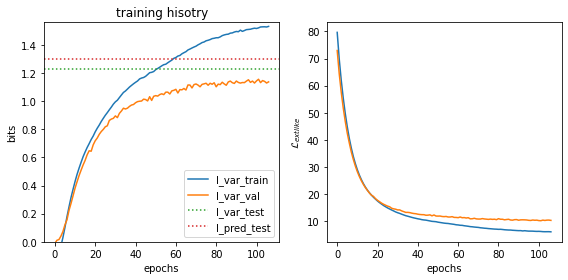

In [124]:
# Get x and y
x_test = test['ID'].values
y_test = test['y'].values

# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,2,figsize=[8,4])
ax[0].plot(I_var_hist, label='I_var_train')
ax[0].plot(val_I_var_hist, label='I_var_val')
ax[0].axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax[0].axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('bits')
ax[0].set_title('training hisotry')
ax[0].set_ylim([0, I_pred*1.2]);

ax[1].plot(model.history['loss'])
ax[1].plot(model.history['val_loss'])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('$\mathcal{L}_{\text{like}}$')

plt.tight_layout()

We can compute predictions $\hat{y}$ on test by calling the `x_to_yhat` method, and plot $y$ against $\hat{y}$ and compute the corresponding $R^2$ value.

Text(0.5, 1.0, 'performance ($R^2$=0.867)')

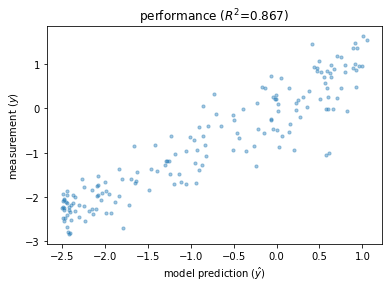

In [125]:
# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)
# Compute R^2 between yhat and y_test
Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2

# Plot y_test vs. yhat_test
fig, ax = plt.subplots(1,1)
ax.scatter(yhat_test, y_test, color='C0', s=10, alpha=.4, label='test data')
ax.set_xlabel('model prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'performance ($R^2$={Rsq:.3})')

We can plot the GE nonlinearity $g(\phi)$ by creating a grid of $\phi$ values and mapping these to $\hat{y}$ values using `model.phi_to_yhat()`. We can plot confidence intervals of $p(y|\hat{y})$ using the function `model.yhat_to_yq()`.

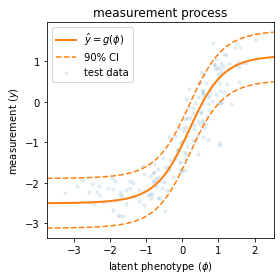

In [126]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=10, alpha=.1, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='90% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

We can visualize the parameters of the G-P map by calling `mavenn.heatmap`

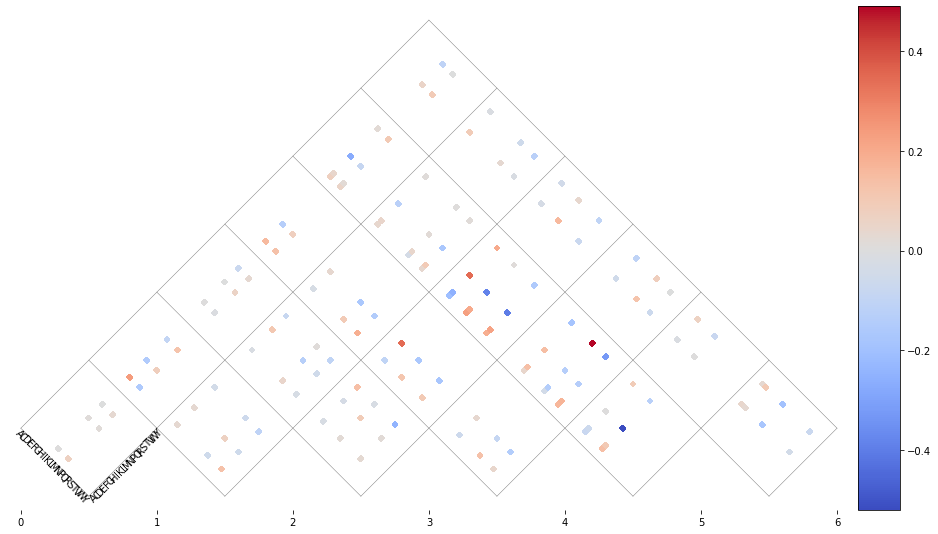

In [127]:
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10]) 
         
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);

In [128]:
#epi_map export
data = theta['theta_lclc']


def array2df(input):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    epi_map=pd.DataFrame()
    for i in range(7):
        for j in range(7):
            map = input[i,:,j,:]
            map_df = pd.DataFrame(map,index=colnames,columns=colnames)
            map_df['L1']=[i+1]*20
            map_df['L2']=[j+1]*20
            epi_map = epi_map.append(map_df)
    return epi_map
                
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
#print(epi_map)
#reformat the dataframe to L1,L2,aa1,aa2,epi
def df2epimap(input):
    epi_df = pd.DataFrame(columns=["L1","L2","AA1","AA2","EPI"])
    for row_index, row in input.iterrows():
        L1=row['L1']
        L2=row['L2']
        AA1=row_index
        row=row.dropna()
        row=row.drop(labels=['L1', 'L2'])
        for col_index, col in row.items():               
            EPI=col
            AA2=col_index
            add_row = [L1,L2,AA1,AA2,EPI]
            add_series = pd.Series(add_row, index = epi_df.columns)
            epi_df = epi_df.append(add_series,ignore_index=True)
    return epi_df
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Bei_epi.csv')
print(epi_df)

      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.002258
1    1.0  2.0   K   N  0.009940
2    1.0  2.0   K   S -0.001055
3    1.0  2.0   N   D  0.070567
4    1.0  2.0   N   N  0.013169
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S  0.102623
149  6.0  7.0   K   L -0.178660
150  6.0  7.0   K   S -0.193960
151  6.0  7.0   T   L -0.041320
152  6.0  7.0   T   S -0.069959

[153 rows x 5 columns]
